In [ ]:
#imports
import time
import qcportal as ptl
import numpy as np
import matplotlib.pyplot as plt
from fragmenter.utils import HARTREE_2_KJMOL
from fragmenter import chemi
from simtk import unit
import os, sys
from fragmenter import chemi
import cmiles
import qcportal as ptl
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import ForceField
from openeye import oechem

In [95]:
#functions 
def torsion_barrier_for_molecule(tdr_object, smiles, show_plots=False):
    """
    Takes in a single torsion drive record that has energies from multiple conformers (at different torsion angles), evaluates the torsion barrier 
    
    Parameters
    ----------
    tdr_object : object
        torsion drive record from QC archive for a molecule
    
    Returns
    -------
    tdr_object.id : int
        id of the TD record
    dihedral_indices: list
        list of atom indices for which torsion is driven in this record
    torsion_barrier: float
        torsion barrier energy in KJ/mol, maximum of all the barriers
    mol: oemol object
        oemol from the smiles in dataframe index
    """
    energies = list(tdr_object.get_final_energies().values())
    tmp = list(tdr_object.get_final_energies().keys())
    angles = [i[0]*np.pi/180 for i in tmp]
    angles, energies = zip(*sorted(zip(angles, energies)))
    angles = np.array(angles)
    energies = np.array(energies)
    angles = np.append(angles[-3:] - 2*np.pi, np.append(angles, angles[:3] + 2*np.pi))
    energies = np.append(energies[-3:], np.append(energies, energies[:3]))
    
    idx = []
    for i in range(len(angles)-2):
        m1 = (energies[i+1]-energies[i])/(angles[i+1]-angles[i])
        m2 = (energies[i+2]-energies[i+1])/(angles[i+2]-angles[i+1])
        if np.sign(m1) == np.sign(m2):
            continue
        else:
            idx.append(i+1)
        
    if (show_plots):
        min_ener = min(energies)
        energies_y = (energies-min_ener)*HARTREE_2_KJMOL
        fontsize = 14
        plt.figure()
        plt.plot(angles*180/np.pi, energies_y, 'b-X', angles[idx]*180/np.pi, energies_y[idx], 'ro')
        plt.legend(['QM data', 'Max, min'], bbox_to_anchor=(1, 1), fontsize=fontsize)
        plt.title('Torsion drive interpolation', fontsize=fontsize)
        plt.xlabel('Dihedral Angle [Degrees]', fontsize=fontsize)
        plt.ylabel('Relative energy [KJ / mol]', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)
        fig_name = 'plot_' + tdr_object.id + '.png'
        plt.savefig(fig_name)
        plt.show()
        
    torsion_barriers = []
    for i in range(int(len(idx)-1)):
        torsion_barriers.append(abs(HARTREE_2_KJMOL*abs(energies[idx[i]] - energies[idx[i+1]])))
    torsion_barriers = np.array(torsion_barriers)
    
    # get dihedral indices and pass on to get_wbo function
    dihedral_indices = list(tdr_object.dict()['keywords']['dihedrals'][0])
    mol = chemi.smiles_to_oemol(smiles)
    mol.SetData("TB", max(torsion_barriers))
    mol.SetData("TDindices", dihedral_indices)
    mol.SetData("TDid", tdr_object.id)
    mol.SetData("cmiles", smiles)
    return mol
    #return(tdr_object.id, dihedral_indices, max(torsion_barriers), mol)


def analyzeTorsion(tID, ff, k1, k2, qcaDS, fileName):
        """
        Description:
        This function takes in a torsion id, and performs analysis on it using a QCA torsion drive dataset
        This function will generate a plot with a .pdf extension

        Input:
        tID: String of a torsion ID from an .offxml format force field e.g. "t43"
        ff: file name of a .offxml style force field
        qcaDS: String of a name of a QCA torsion drive dataset
        fileName: String for the .pdf file name of the plot of WBO versus torsion drive barrier
        k1: Float of the force constant for wiberg bond order equal to 1 for the specified torsion
        k2: Float of the force constant for wiberg bond order equal to 2 for the specified torsion

        Return:
        resultDict: A dictionary of the results from the residual calculation. The key is the smiles and the
        items is a list of the [torsion barrier hieght, WBO, residual].
        """

        #WIP Load in the QCA dataset, convert the dataset into OEMols with data tags containing WBO and torsion barrier height
        molList = loadDataset(qcaDS)


        molsTorsion=[]
        for mol in molList:
            status = checkTorsion(tID, ff, mol)
            if status == True:
                molsTorsion.append(mol)

        resultDict={}

        for m in molsTorsion:
            resultDict[OEMolsToSmiles(m)]= [m.GetData("TorsionBarrier"), m.GetData("WBO"), getResidual(m, k1, k2)]

        plotResults(resultDict, fileName, k1, k2)


        return resultDict

def loadDataset(datasets):
    """
        To load torsion drive datasets and return a list of molecules with torsion barriers and associated wiberg bond order
        
        Parameters
        ----------
        datasets : list of tuples containing the dataset name and specification
        
        Returns
        -------
        molList : each row contains the tdr_object.id, oemol_object, dihedral_indices, torsion_barrier, wbo
    """
    molList = []
    for dataset_tuple in datasets:
        print("Reading dataset: ", dataset_tuple[0], ", and specification: ", dataset_tuple[1])
        molList.extend(loadDataset_low(dataset_tuple[0], dataset_tuple[1]))

    return molList
    

def loadDataset_low(datasetName, specification):
    """
    Low level call to load each torsion drive dataset and return a list of molecules
    
        Parameters
        ----------
        datasetName : str
            torsion drive dataset name.  
        specification : str
            specification in the dataset. Example: "B3LYP-D3", "default", "UFF" 
        
        Returns
        -------
        molList : list of objects
            each row contains the tdr_object.id, dihedral_indices, torsion_barrier, oemol_object
    """
    while True:    
        try:
            assert(datasetName)
            break
        except AssertionError:
            print ("datasetName is empty. Check input list of dataset tuples")
            raise
    while True:    
        try:
            assert(specification)
            break
        except AssertionError:
            print ("specification is empty. Check input list of dataset tuples")
            raise

    # initiate qc portal instance
    client = ptl.FractalClient()    
    # from the TorsionDriveDataset collection picking up given datasetName
    ds = client.get_collection("TorsionDriveDataset", datasetName)
    ds.status([specification], status="COMPLETE")
 
    # Serial implementation
    tb = []
    for i in range(ds.df.size):
        if (ds.df.iloc[i,0].status == 'COMPLETE'):
            smiles = ds.df.index[i]
            print(smiles)
            cmiles_ids = cmiles.get_molecule_ids(smiles, strict=False)
            #mapped_smiles = cmiles_ids['canonical_isomeric_explicit_hydrogen_mapped_smiles']
            mapped_smiles = ds.get_entry(smiles).attributes['canonical_isomeric_explicit_hydrogen_mapped_smiles']
            
            tb.append(torsion_barrier_for_molecule(ds.df.iloc[i, 0], mapped_smiles))
    print("Total records processed for this dataset:", len(tb), "out of ", len(ds.df))
    return(tb)



def getResidual(oemol, k1, k2):
    """
    Description:
    Finds the residual of an oemol by taking the input k1 and k2 values and finding the y=mx+b form and calculates
    the difference from the wbo, torsion barrier height point

    input:
    oemol: OEMol from oechem, contains datatags for WBO and torsion barrier height
    k1: Float of the force constant for wiberg bond order equal to 1 for the specified torsion
    k2: Float of the force constant for wiberg bond order equal to 2 for the specified torsion
    """
    #WIP

    return residual

def plotResult(resultDict, filename, k1, k2):
    """
    Description:
    Creates a scatter plot of WBO versus the torsion barrier height with the y=mx + b form of the torsion interpolation.
    Saves plot to .pdf

    Input:
    resultDict: Dictionary of the data for plotting. The keys are smiles, and the items are a list of WBO, torsion barrier height
    and residual
    fileName: Name of file to save .pdf form of the plot
    k1: Float of the force constant for wiberg bond order equal to 1 for the specified torsion
    k2: Float of the force constant for wiberg bond order equal to 2 for the specified torsion

    return:
    """
    #WIP
    return


def checkTorsion(molList):
    """
    definition: takem ollist and check if the molecules in a list match a specific torsion id
    """
    matches=[]
    count=0
    mols=[]
    for mol in molList: 
        molecule = Molecule.from_mapped_smiles(mol.GetData("cmiles"))
        #molecule=Molecule.from_openeye(mol)
        topology = Topology.from_molecules(molecule)
        # Let's label using the Parsley force field
        forcefield = ForceField('openff-1.2.1.offxml')
        # Run the molecule labeling
        molecule_force_list = forcefield.label_molecules(topology)
        params=[]
        # Print out a formatted description of the torsion parameters applied to this molecule
        for mol_idx, mol_forces in enumerate(molecule_force_list):
            #print(f'Forces for molecule {mol_idx}')
            for force_tag, force_dict in mol_forces.items():
                if force_tag == 'ProperTorsions':
                    for (atom_indices, parameter) in force_dict.items():
                        atomList=[]
                        for idx in atom_indices:
                            atomList.append(idx)
                        params.append(parameter.id)
                        if atomList == mol.GetData("TDindices") or atomList[::-1] == mol.GetData("TDindices"):
                            count+=1
                            mol.SetData("IDMatch", parameter.id)
                            mols.append(mol)
    print(count)
    print(len(molList))
    
    return mols 






def calcWBO(molList):
    mols=[]
    errors=[]
    for mol in molList:
        charged = chemi.get_charges(mol)
        for bond in charged.GetBonds():
            #m1 = bond.GetBgn().GetMapIdx()
            #m2 = bond.GetEnd().GetMapIdx()
            m1=bond.GetBgnIdx()
            m2=bond.GetEndIdx()
            index=mol.GetData("TDindices")
            print(m1)
            print(m2)
            print(index[1])
            print(index[2])
            if m1 in [index[1], index[2]]:
                if m2 in [index[1], index[2]]:
                    print("match")
                    #if (m1 in map_idx or m2 in map_idx) and not bond.IsInRing():
                    try: 
                        wbo = bond.GetData('WibergBondOrder')
                        print(wbo)
                        mol.SetData("WBO", wbo)
                        mols.append(mol)
                    except: 
                        errors.append(mol)
                        pass
    print(len(mols))
    print(len(molList))
    return mols, errors
    





def makeOEB(oemolList, tag):
    """
    Description:
    Takes in an oemol list and creates an output OEB file.

    Input:
    oemolList: A list of oemols
    tag: The title of the OEB file.

    Return:

    """
    ofile = oechem.oemolostream(tag+'.oeb')
    for mol in oemolList:
        oechem.OEWriteConstMolecule(ofile, mol)
    ofile.close()
    return







In [96]:
#datasetName="OpenFF Gen 2 Torsion Set 5 Bayer"
datasetName="OpenFF Full TorsionDrive Benchmark 1"
#datasetName='OpenFF Substituted Phenyl Set 1'
#datasetName="OpenFF Rowley Biaryl v1.0"
molList=loadDataset_low(datasetName, "default")

#for mol in molList:
#    print(mol.GetData("TDindices"))
    
mols=checkTorsion(molList)
print(mols)

molsWBO= calcWBO(mols)
print(molsWBO[0])



makeOEB(molsWBO[0], "benchmark")
makeOEB(molsWBO[1], "benchmark")


#makeOEB(molsWBO[0], "bayer")
#makeOEB(molsWBO[1], "errors_bayer")


#makeOEB(molsWBO[0], "rowley")
#makeOEB(molsWBO[1], "errors_rowley")


#makeOEB(molsWBO[0], "phenyl")
#makeOEB(molsWBO[1], "errors_phenyl.oeb")

#makeOEB(molsWBO[0], "openFFGen2TorsionSet5Bayer.oeb")
#makeOEB(molsWBO[1], "errors_openFFGen2TorsionSet5Bayer.oeb")


1


ValueError: The supplied SMILES 1 could not be parsed

In [105]:
from scipy import stats
import arch.bootstrap
import fragmenter 

#slope, intercept, r_value, p_value, std_err = stats.linregress(wbos1, max_energies)
def compute_r_ci(wbos, max_energies):
    return (stats.linregress(wbos, max_energies)[2])**2


def oeb2oemol(oebfile):
    """
    Takes in oebfile and generates oemolList
    input:
    oebfile: Oebfile (.oeb)

    return:
    mollist: List of oemols

    """

    ifs = oechem.oemolistream(oebfile)
    mollist = []

    for mol in ifs.GetOEGraphMols():
            mollist.append(oechem.OEGraphMol(mol))

    return mollist



def visualize_wbo_correlation(fileName, fname):
    
    molList=oeb2oemol(fileName)
    
    torsionDict={}
    print(molList)
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]={}
        torsionDict[tid]['tb']=[]
        torsionDict[tid]['wbo']=[]
    print(torsionDict)
    
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]['tb'].append(m.GetData("TB"))
        torsionDict[tid]['wbo'].append(m.GetData("WBO"))
    print(torsionDict)
    
    
    
    colors = fragmenter.chemi._KELLYS_COLORS
    #fig, ax = plt.subplots()
    
    fig,ax=plt.subplots()

    for i, (key, item) in enumerate(torsionDict.items()):
        ax.scatter(torsionDict[key]['wbo'],torsionDict[key]['tb'],c=colors[i], label=key)
        slope, intercept, r_value, p_value, std_err = stats.linregress(torsionDict[key]['wbo'], torsionDict[key]['tb'])
        print(key)
        print(r_value)
        print(slope)
        print(intercept)
        ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(torsionDict[key]['wbo']), np.asarray(torsionDict[key]['tb'])).conf_int(compute_r_ci, 1000)
        CI_95 = 1.96*std_err
        plt.plot(np.unique(torsionDict[key]['wbo']), np.poly1d([slope, intercept])(np.unique(torsionDict[key]['wbo'])), c=colors[i])


        
        
        #ax.scatter(range(len(geo1_labels)),ali_geo1_ys,facecolors="None",edgecolors="r",marker="s")
    #ax.set_xticks(range(len(geo1_labels)) )
    #ax.set_xticklabels(geo1_labels,rotation=90)
    #props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    #ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
    #        verticalalignment='top', bbox=props);
    
    l = ax.legend(bbox_to_anchor=(1, 1), fontsize=14)

    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    
    """
    angles = np.arange(-170, 170, 25)

    colors = fragmenter.chemi._KELLYS_COLORS
    fig, ax = plt.subplots()
    
    
    #max_energies = [max(e) for e in energies]
    max_energies=[]
    for e in energies:
        print(len(e))
        #ang=[(-150,), (-60,), (-30,), (60,), (90,), (180,), (-165,), (-135,), (-75,), (-45,), (-15,), (45,), (75,), (105,), (165,), (-120,), (-90,), (0,), (30,), (120,), (150,), (-105,), (15,), (135,)]
        #angles = [i[0]*np.pi/180 for i in ang]
        angles = np.arange(-170, 170, 13.6)
        print("length of angles:" + str(len(angles)))
        #angles, energies = zip(*sorted(zip(angles, energies)))
        #angles = np.array(angles)
        print(len(angles))
        print(angles)
        #spl = UnivariateSpline(angles, e, k=4, s=0)
        
        print("length of angles:" + str(len(angles)))
        print("length of energies:" + str(len(e)))
        spl = UnivariateSpline(angles, e, k=4, s=0)

        #try pavan's max energy method 
        # finding roots
        roots = spl.derivative().roots() * 180/ np.pi
        # corresponding energies    
        energy_maxmin = spl(roots*np.pi/180)
        # for the barrier: considering the (global) maximum of the energies from this torsiondrive
        # (fitted to a spline) and subtracting with adjacent minima 
        # (maxima's index incremented/decremented by 1)
        max_energy_index = np.argmax(energy_maxmin)
        if (max_energy_index + 1) < roots.size:
            next_min_index = max_energy_index + 1
        else:
            next_min_index = max_energy_index - 1
        torsion_barrier = energy_maxmin[max_energy_index] - energy_maxmin[next_min_index]
        max_energies.append(torsion_barrier)

    
    
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(wbos, max_energies)
    print(slope)
    print(intercept)
    ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(wbos), np.asarray(max_energies)).conf_int(compute_r_ci, 1000)
    CI_95 = 1.96*std_err
    plt.plot(np.unique(wbos), np.poly1d([slope, intercept])(np.unique(wbos)), 'black')
    for i, (wbo, en) in enumerate(zip(wbos, max_energies)):
        plt.scatter(wbo, en, c=colors[i], linewidths=5)
    textstr = '\n'.join((
        r'slope=%.2f$_{%.2f}^{%.2f}$' % (slope, slope-CI_95, slope+CI_95),
        r'$r^2=%.2f_{%.2f}^{%.2f}$' % (r_value**2, ci_r_value[0], ci_r_value[1])))
        #r'P value=%.3f' % (p_value, ),
        #r'standard error=%.2f' % (std_err, )))
    props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props);
    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight');
    """


[<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x131a54a20> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x11c444db0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12cafe5d0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be2d0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be630> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be960> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be180> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be3f0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be780> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be810> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393bed50> >

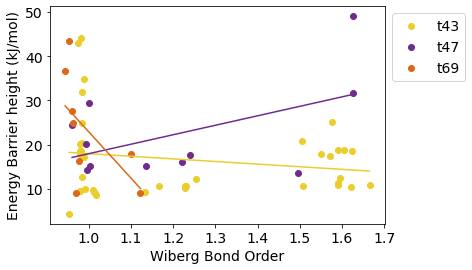

In [108]:
visualize_wbo_correlation('rowley.oeb', 'rowley.pdf')

[<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x128f8d4b0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12cafe5a0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x131fabab0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be570> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be840> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393bea80> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393befc0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be090> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be0f0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be900> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1393be930> >

t96
0.8899074404274189
162.88522917902029
-156.38450247662013
t72
0.9807385265706327
392.4366104856236
-310.9887503647536


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


t47
0.7284102106111198
164.72170086258006
-125.10433627938869


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


t74
0.0
nan
nan
t97
0.8498903609186031
154.52944472939848
-147.86827919802917
t43
0.8662198062958578
152.7973729634531
-128.8358689150425


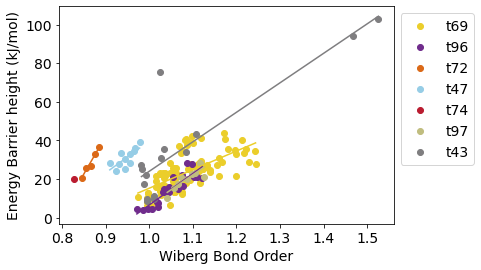

In [107]:
visualize_wbo_correlation('phenyl.oeb', 'phenyl.pdf')

[<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x11c444d80> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x132128180> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b69f0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b6ba0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b6bd0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b6990> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b6a50> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b6a80> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b66f0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b6810> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12e9b68d0> >

/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r

nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


nan
nan


IndexError: list index out of range

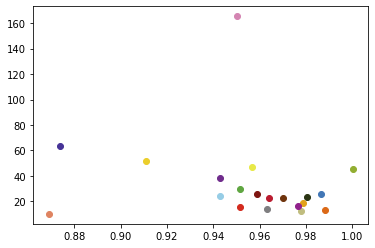

In [87]:
visualize_wbo_correlation('bayer.oeb', 'bayer.pdf')

No handles with labels found to put in legend.


[]
{}
{}


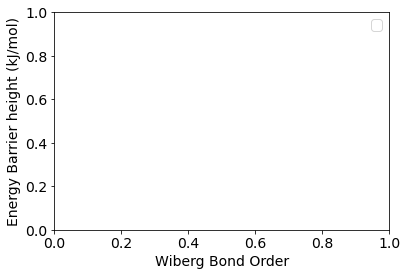

In [92]:
visualize_wbo_correlation('frag.oeb', 'frag.pdf')

In [110]:

def visualize_wbo_correlation_compare(fileName, fileName2, fname):
    
    molList=oeb2oemol(fileName)
    torsionDict={}
    print(molList)
    torsionDict2={}

    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]={}
        torsionDict[tid]['tb']=[]
        torsionDict[tid]['wbo']=[]
        torsionDict2[tid]={}
        torsionDict2[tid]['tb']=[]
        torsionDict2[tid]['wbo']=[]
    print(torsionDict)
    
    
    for m in molList:
        tid=m.GetData("IDMatch")
        torsionDict[tid]['tb'].append(m.GetData("TB"))
        torsionDict[tid]['wbo'].append(m.GetData("WBO"))
    print(torsionDict)
    
    
    molList2=oeb2oemol(fileName2)
    print(molList2)
    
    for m in molList2:
        tid=m.GetData("IDMatch")
        torsionDict2[tid]={}
        torsionDict2[tid]['tb']=[]
        torsionDict2[tid]['wbo']=[]
    print(torsionDict2)
    
    
    for m in molList2:
        tid=m.GetData("IDMatch")
        torsionDict2[tid]['tb'].append(m.GetData("TB"))
        torsionDict2[tid]['wbo'].append(m.GetData("WBO"))
    print(torsionDict2)
    
    
    
    
    
    colors = fragmenter.chemi._KELLYS_COLORS
    #fig, ax = plt.subplots()
    
    fig,ax=plt.subplots()

    for i, (key, item) in enumerate(torsionDict.items()):
        ax.scatter(torsionDict[key]['wbo'],torsionDict[key]['tb'],c=colors[i], label=key, marker='o')
        ax.scatter(torsionDict2[key]['wbo'],torsionDict2[key]['tb'],c=colors[i], marker='x')
        slope, intercept, r_value, p_value, std_err = stats.linregress(torsionDict[key]['wbo']+torsionDict2[key]['wbo'], torsionDict[key]['tb']+torsionDict2[key]['tb'])
        print(key)
        print(r_value)
        
        print(slope)
        print(intercept)
        ci_r_value = arch.bootstrap.IIDBootstrap(np.asarray(torsionDict[key]['wbo']+torsionDict2[key]['wbo']), np.asarray(torsionDict[key]['tb']+torsionDict2[key]['tb'])).conf_int(compute_r_ci, 1000)
        CI_95 = 1.96*std_err
        plt.plot(np.unique(torsionDict[key]['wbo']+torsionDict2[key]['wbo']), np.poly1d([slope, intercept])(np.unique(torsionDict[key]['wbo']+torsionDict2[key]['wbo'])), c=colors[i])


        
        
    #ax.scatter(range(len(geo1_labels)),ali_geo1_ys,facecolors="None",edgecolors="r",marker="s")
    #ax.set_xticks(range(len(geo1_labels)) )
    #ax.set_xticklabels(geo1_labels,rotation=90)
    #props = dict(boxstyle='square', facecolor='white', alpha=0.5)
    #ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
    #        verticalalignment='top', bbox=props);
    
    l = ax.legend(bbox_to_anchor=(1, 1), fontsize=14)

    plt.xlabel('Wiberg Bond Order', fontsize=14);
    plt.ylabel('Energy Barrier height (kJ/mol)', fontsize=14);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig(fname, bbox_inches='tight')
    plt.show()
    

[<oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x13adcf030> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12c007240> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x1319827b0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12cafe5d0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f40c0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f4390> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f4240> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f4450> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f4330> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f45a0> >, <oechem.OEGraphMol; proxy of <Swig Object of type 'OEGraphMolWrapper *' at 0x12d4f45d0> >

t96
0.8899074404274189
162.88522917902029
-156.38450247662013
t72
0.9807385265706327
392.4366104856236
-310.9887503647536


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


t47
0.07124188652355991
2.914391752632189
23.490375312386348


/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/jessica/miniconda3/envs/openff-dev/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


t74
0.0
nan
nan
t97
0.8498903609186031
154.52944472939848
-147.86827919802917
t43
0.06511206289378871
4.986481180089412
16.270514293036126


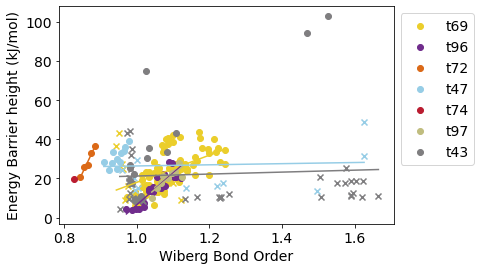

In [111]:
visualize_wbo_correlation_compare('phenyl.oeb', 'rowley.oeb', 'compare.pdf')